# Vehicle Detection Using YOLOv8

## 1. Introduction

This project focuses on real-time vehicle detection using YOLOv8, a state-of-the-art object detection model. The KITTI dataset ([source](https://www.kaggle.com/datasets/klemenko/kitti-dataset)) was used for training and evaluation, providing high-quality annotated images of vehicles in diverse driving environments. The goal is to accurately detect and classify vehicles in images and videos, enabling applications in traffic monitoring, autonomous driving, and surveillance.

## 2. Dataset Preprocessing

In [ ]:
import kagglehub
import matplotlib.pyplot as plt
import numpy as np # type: ignore
import os
import shutil
import random
import cv2
from ultralytics import YOLO 
from shutil import copyfile
from collections import defaultdict
import albumentations as A

Firstly download the dataset from **kagglehub**

In [ ]:
# Download latest version
path = kagglehub.dataset_download("klemenko/kitti-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/kitti-dataset


I reorganized the **KITTI dataset** by filtering out unnecessary data and structuring it for YOLOv8 training. First, I defined the paths for images and labels, then created directories for training and validation sets. The dataset was shuffled and split (80% training, 20% validation). Finally, images and corresponding label files were moved into their respective folders to ensure a clean and structured dataset for model training.

In [ ]:
# Define paths
dataset_path = path 
images_src = os.path.join(dataset_path, "data_object_image_2/training/image_2")  
labels_src = os.path.join(dataset_path, "data_object_label_2/training/label_2") 

# Define new dataset structure
output_dir = "data"
train_images_dir = os.path.join(output_dir, "train/images")
train_labels_dir = os.path.join(output_dir, "train/labels")
val_images_dir = os.path.join(output_dir, "val/images")
val_labels_dir = os.path.join(output_dir, "val/labels")

# Create necessary directories
for dir_path in [train_images_dir, train_labels_dir, val_images_dir, val_labels_dir]:
    os.makedirs(dir_path, exist_ok=True)

# Get a list of image files
image_files = [f for f in os.listdir(images_src) if f.endswith(".png")]
image_files.sort()  # Ensure consistent order

# Shuffle and split data
random.seed(42)  # For reproducibility
random.shuffle(image_files)

split_idx = int(len(image_files) * 0.8)  # 80% train, 20% val
train_files = image_files[:split_idx]
val_files = image_files[split_idx:]

# Function to move files
def move_files(file_list, src_folder, dest_folder, ext):
    for file in file_list:
        file_name = os.path.splitext(file)[0]  # Remove .png extension
        src_file = os.path.join(src_folder, file_name + ext)
        dest_file = os.path.join(dest_folder, file_name + ext)
        if os.path.exists(src_file):  # Move only if file exists
            shutil.copy(src_file, dest_file)

# Move train images and labels
move_files(train_files, images_src, train_images_dir, ".png")
move_files(train_files, labels_src, train_labels_dir, ".txt")

# Move validation images and labels
move_files(val_files, images_src, val_images_dir, ".png")
move_files(val_files, labels_src, val_labels_dir, ".txt")

print("✅ Dataset organized successfully!")

✅ Dataset organized successfully!


To ensure the dataset was correctly organized, I checked the number of images and labels in each directory. The script verified the existence of the data folder, displayed its structure, and counted the files in train and validation sets.

In [ ]:
# Define the main dataset folder
data_dir = "data"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

# Check if "data" folder exists
if os.path.exists(data_dir) and os.path.isdir(data_dir):
    print("✅ The 'data' folder exists in the working directory!")
    
    # List contents of "data" folder
    print("\n📂 Contents of 'data':", os.listdir(data_dir))
    
    # Check contents inside "train" and "val" folders
    if os.path.exists(train_dir):
        print("\n📂 Contents of 'train':", os.listdir(train_dir))
    else:
        print("\n❌ 'train' folder not found inside 'data'.")

    if os.path.exists(val_dir):
        print("\n📂 Contents of 'val':", os.listdir(val_dir))
    else:
        print("\n❌ 'val' folder not found inside 'data'.")

    # Count number of files in train/images and train/labels
    train_images_dir = os.path.join(train_dir, "images")
    train_labels_dir = os.path.join(train_dir, "labels")

    if os.path.exists(train_images_dir):
        num_train_images = len([f for f in os.listdir(train_images_dir) if os.path.isfile(os.path.join(train_images_dir, f))])
        print(f"📸 Number of train images: {num_train_images}")
    else:
        print("❌ Train images folder not found.")

    if os.path.exists(train_labels_dir):
        num_train_labels = len([f for f in os.listdir(train_labels_dir) if os.path.isfile(os.path.join(train_labels_dir, f))])
        print(f"📝 Number of train labels: {num_train_labels}")
    else:
        print("❌ Train labels folder not found.")

    # Count number of files in val/images and val/labels
    val_images_dir = os.path.join(val_dir, "images")
    val_labels_dir = os.path.join(val_dir, "labels")

    if os.path.exists(val_images_dir):
        num_val_images = len([f for f in os.listdir(val_images_dir) if os.path.isfile(os.path.join(val_images_dir, f))])
        print(f"📸 Number of val images: {num_val_images}")
    else:
        print("❌ Val images folder not found.")

    if os.path.exists(val_labels_dir):
        num_val_labels = len([f for f in os.listdir(val_labels_dir) if os.path.isfile(os.path.join(val_labels_dir, f))])
        print(f"📝 Number of val labels: {num_val_labels}")
    else:
        print("❌ Val labels folder not found.")

else:
    print("❌ The 'data' folder is NOT in the working directory.")


✅ The 'data' folder exists in the working directory!

📂 Contents of 'data': ['train', 'val']

📂 Contents of 'train': ['images', 'labels']

📂 Contents of 'val': ['images', 'labels']
📸 Number of train images: 5984
📝 Number of train labels: 5984
📸 Number of val images: 1497
📝 Number of val labels: 1497


The dataset was successfully prepared for training. The train folder contains 5,984 images and labels, while the val folder contains 1,497 images and labels, confirming a correct 80/20 split. Everything is set up properly for model training on **Kaggle**. 

## 3. Dataset Analysis and Balancing

### 3.1 Class Distribution Analysis & YOLO Label Preparation

To ensure balanced training, I analyzed the dataset to check how many images contain each class. By converting KITTI labels to YOLO format, I extracted class-wise image counts. This helps identify class imbalances, where some categories, like Car (6684 images), are overrepresented, while others, like Person_sitting (99 images), are underrepresented.

In [ ]:
# Function to find all unique class names
def find_unique_classes(labels_path):
    unique_classes = set()
    
    for split in ["train", "val"]:
        labels_dir = os.path.join(labels_path, split, "labels")
        
        for label_file in os.listdir(labels_dir):
            label_path = os.path.join(labels_dir, label_file)
            
            with open(label_path, "r") as file:
                lines = file.readlines()
            
            for line in lines:
                class_name = line.strip().split()[0]  # Get class name
                if class_name != "DontCare":  # Ignore "DontCare" objects
                    unique_classes.add(class_name)
    
    return sorted(list(unique_classes))  # Sort for consistency

# Step 1: Find all unique classes
unique_classes = find_unique_classes(dataset_path)

# Step 2: Assign a unique class ID for YOLO
class_mapping = {name: idx for idx, name in enumerate(unique_classes)}

# Dictionary to track the number of images containing each class
class_image_count = defaultdict(int)

# Function to convert KITTI labels to YOLO format
def convert_kitti_to_yolo(label_path, image_width=1242, image_height=375):
    yolo_labels = []
    image_classes = set()  # Track unique classes in this image
    
    with open(label_path, "r") as file:
        lines = file.readlines()
    
    for line in lines:
        parts = line.strip().split()
        
        class_name = parts[0]
        if class_name == "DontCare":
            continue  # Skip DontCare objects
        
        class_id = class_mapping.get(class_name, None)
        if class_id is None:
            continue  # Ignore unlisted classes
        
        # Track that this class appears in the image
        image_classes.add(class_name)

        # Extract bounding box (xmin, ymin, xmax, ymax)
        xmin, ymin, xmax, ymax = map(float, parts[4:8])

        # Convert to YOLO format (normalized)
        x_center = ((xmin + xmax) / 2) / image_width
        y_center = ((ymin + ymax) / 2) / image_height
        width = (xmax - xmin) / image_width
        height = (ymax - ymin) / image_height

        # Store in YOLO format
        yolo_labels.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    # Increment class image count for each unique class in the image
    for class_name in image_classes:
        class_image_count[class_name] += 1

    return yolo_labels

# Step 3: Process all label files in train and val folders
for split in ["train", "val"]:
    labels_dir = os.path.join(dataset_path, split, "labels")
    
    for label_file in os.listdir(labels_dir):
        label_path = os.path.join(labels_dir, label_file)
        
        # Convert labels
        yolo_labels = convert_kitti_to_yolo(label_path)
        
        # Save back in YOLO format
        with open(label_path, "w") as file:
            file.write("\n".join(yolo_labels))

# Step 4: Output the class mappings and image counts
print("✅ KITTI labels successfully converted to YOLO format!")
print("\n📌 Found classes and assigned YOLO class IDs:")
for class_name, class_id in class_mapping.items():
    print(f"  - {class_name} → {class_id}")

print("\n📊 Number of images containing each class:")
for class_name, count in class_image_count.items():
    print(f"  - {class_name}: {count} images")


✅ KITTI labels successfully converted to YOLO format!

📌 Found classes and assigned YOLO class IDs:
  - Car → 0
  - Cyclist → 1
  - Misc → 2
  - Pedestrian → 3
  - Person_sitting → 4
  - Tram → 5
  - Truck → 6
  - Van → 7

📊 Number of images containing each class:
  - Car: 6684 images
  - Van: 2145 images
  - Truck: 1036 images
  - Pedestrian: 1779 images
  - Tram: 349 images
  - Cyclist: 1141 images
  - Person_sitting: 99 images
  - Misc: 778 images


The dataset is highly imbalanced, which could impact model performance. To address this, I will stabilize class distributions using:

- Downsampling Cars to reduce **overrepresentation**.
- Oversampling minority classes with augmentations.
- Generating synthetic Person_sitting instances using GANs to improve representation.

This will create a more balanced dataset for better detection accuracy. 

### 3.2 Downsampling Overrepresented Classes

To balance the dataset, I downsampled the Car class, which had an excessive number of instances. I randomly selected 3,500 car instances and removed the excess while keeping other classes unchanged. The filtered images and labels were saved to a new balanced dataset folder, ensuring a more even class distribution.

This step helps prevent the model from being biased toward Cars, improving detection accuracy across all classes. 

In [ ]:
# Paths
train_path = "/kaggle/working/data/train"
images_dir = os.path.join(train_path, "images")
labels_dir = os.path.join(train_path, "labels")

balanced_path = "/kaggle/working/data/balanced"
os.makedirs(balanced_path, exist_ok=True)
balanced_images = os.path.join(balanced_path, "images")
balanced_labels = os.path.join(balanced_path, "labels")
os.makedirs(balanced_images, exist_ok=True)
os.makedirs(balanced_labels, exist_ok=True)

# Collect all Car instances
car_instances = []
for label_file in os.listdir(labels_dir):
    label_path = os.path.join(labels_dir, label_file)
    if not os.path.isfile(label_path):
        continue  # Skip directories
    with open(label_path, 'r') as f:
        for line in f:
            if line.startswith('0 '):
                car_instances.append((label_file, line.strip()))

# Select 4000 instances
random.seed(42)
selected_cars = random.sample(car_instances, 3500)

# Group selected cars by their label file
selected_by_file = defaultdict(list)
for label_file, car_line in selected_cars:
    selected_by_file[label_file].append(car_line)

# Process each image
for label_file in os.listdir(labels_dir):
    label_path = os.path.join(labels_dir, label_file)
    if not os.path.isfile(label_path):
        continue
    
    # Check for both .jpg and .png extensions
    base_name = os.path.splitext(label_file)[0]
    for ext in ['.jpg', '.jpeg', '.png']:
        image_file = base_name + ext
        src_image = os.path.join(images_dir, image_file)
        if os.path.exists(src_image):
            break
    else:
        print(f"Warning: No image found for {label_file}")
        continue

    # Read original labels
    with open(label_path, 'r') as f:
        lines = [line.strip() for line in f]
    
    # Filter selected Cars and keep others
    new_lines = []
    for line in lines:
        if line.startswith('0 '):
            if line in selected_by_file.get(label_file, []):
                new_lines.append(line)
        else:
            new_lines.append(line)
    
    # Save if not empty
    if new_lines:
        copyfile(src_image, os.path.join(balanced_images, image_file))
        with open(os.path.join(balanced_labels, label_file), 'w') as f:
            f.write('\n'.join(new_lines))

### 3.3 Oversampling Minority Classes with Augmentation

To balance the dataset, I applied data augmentation to increase the number of samples for underrepresented classes (Cyclist, Misc, Tram, Truck, and Van). Using transformations like flipping, rotation, brightness adjustment, and padding, I generated additional images while ensuring valid bounding boxes.

In [ ]:
# Enhanced augmentation pipeline with safety constraints
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5, border_mode=cv2.BORDER_CONSTANT),
    A.RandomBrightnessContrast(p=0.2),
    A.PadIfNeeded(min_height=416, min_width=416, p=1.0)
], bbox_params=A.BboxParams(
    format='yolo',
    label_fields=['class_ids'],
    min_area=0.001,  # Discard boxes smaller than 0.1% of image area
    min_visibility=0.1  # Discard boxes with <10% visibility
))

def validate_bbox(bbox):
    """Clamp bbox coordinates to [0,1] with precision handling"""
    return [
        max(0.0, min(1.0, round(float(bbox[0]), 6))),
        max(0.0, min(1.0, round(float(bbox[1]), 6))),
        max(0.0, min(1.0, round(float(bbox[2]), 6))),
        max(0.0, min(1.0, round(float(bbox[3]), 6)))
    ]

classes_to_oversample = {1: 3000, 2: 3000, 5: 3000, 6: 3000, 7: 3000}

for class_id, target in classes_to_oversample.items():
    # Collect instances with enhanced validation
    instances = []
    for label_file in os.listdir(labels_dir):
        label_path = os.path.join(labels_dir, label_file)
        if not os.path.isfile(label_path):
            continue
        
        # Find corresponding image with extension check
        base_name = os.path.splitext(label_file)[0]
        image_path = None
        for ext in ['.jpg', '.jpeg', '.png']:
            test_path = os.path.join(images_dir, f"{base_name}{ext}")
            if os.path.exists(test_path):
                image_path = test_path
                break
        if not image_path:
            continue

        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue  # Skip invalid lines
                
                try:
                    if int(parts[0]) == class_id:
                        validated_bbox = validate_bbox(parts[1:5])
                        instances.append((label_file, parts, image_path))
                except ValueError:
                    continue
    
    needed = max(target - len(instances), 0)
    print(f"Class {class_id}: Starting with {len(instances)} samples, needing {needed} more")
    
    # Augmentation with retry logic
    success_count = 0
    attempt = 0
    while success_count < needed and attempt < needed * 3:  # Prevent infinite loops
        attempt += 1
        
        # Select random instance
        label_file, parts, image_path = random.choice(instances)
        
        # Load and validate image
        image = cv2.imread(image_path)
        if image is None:
            continue
            
        try:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except:
            continue

        # Validate and prepare bbox
        try:
            bbox = validate_bbox(parts[1:5])
            if sum(bbox[2:]) < 0.01:  # Skip tiny boxes
                continue
        except:
            continue

        # Apply augmentation
        try:
            transformed = aug(image=image, bboxes=[bbox], class_ids=[class_id])
            aug_image = transformed['image']
            aug_bboxes = transformed['bboxes']
            
            if len(aug_bboxes) == 0:
                continue
                
            # Final validation
            aug_bbox = validate_bbox(aug_bboxes[0])
            if (aug_bbox[0] >= 0 and aug_bbox[1] >= 0 and
                (aug_bbox[0] + aug_bbox[2]) <= 1.0 and
                (aug_bbox[1] + aug_bbox[3]) <= 1.0):
                
                # Save successful augmentation
                aug_image_name = f"aug_{class_id}_{success_count}.jpg"
                aug_label_name = f"aug_{class_id}_{success_count}.txt"
                cv2.imwrite(os.path.join(balanced_images, aug_image_name),
                          cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))
                with open(os.path.join(balanced_labels, aug_label_name), 'w') as f:
                    f.write(f"{class_id} {' '.join(map(str, aug_bbox))}")
                success_count += 1
                
        except Exception as e:
            continue

    print(f"Class {class_id}: Generated {success_count}/{needed} valid augmentations")

Class 1: Starting with 1321 samples, needing 1679 more
Class 1: Generated 1679/1679 valid augmentations
Class 2: Starting with 778 samples, needing 2222 more
Class 2: Generated 2222/2222 valid augmentations
Class 5: Starting with 412 samples, needing 2588 more
Class 5: Generated 2588/2588 valid augmentations
Class 6: Starting with 896 samples, needing 2104 more
Class 6: Generated 2104/2104 valid augmentations
Class 7: Starting with 2351 samples, needing 649 more
Class 7: Generated 649/649 valid augmentations


The augmentation pipeline successfully increased the dataset size for minority classes, improving balance and helping the model generalize better.

### 3.4 Dataset Sanity Check

To ensure data quality, I performed a sanity check on the dataset by verifying that all label files contain valid YOLO-formatted bounding boxes. The script checked for:

- Missing or incorrectly formatted bounding boxes.
- Bounding boxes outside the valid range (0 to 1).

In [ ]:
def verify_dataset(labels_dir, images_dir):
    bad_files = []
    for label_file in os.listdir(labels_dir):
        label_path = os.path.join(labels_dir, label_file)
        with open(label_path, 'r') as f:
            for i, line in enumerate(f):
                parts = line.strip().split()
                if len(parts) != 5:
                    bad_files.append(f"{label_file}: line {i+1}")
                    continue
                try:
                    bbox = list(map(float, parts[1:5]))
                    if any(not (0 <= x <= 1) for x in bbox):
                        bad_files.append(f"{label_file}: invalid bbox {bbox}")
                except:
                    bad_files.append(f"{label_file}: non-float values")
    
    print("Invalid labels:", "\n".join(bad_files))

verify_dataset(labels_dir, images_dir)

Invalid labels: 


No errors were found, confirming that the dataset is clean and ready for training. 

### 3.5 Generating Synthetic Person_sitting Instances

The Person_sitting class had only 99 images, making it severely underrepresented. To improve detection accuracy, I generated 1,500 synthetic instances by:

- Extracting Person_sitting patches from existing images.
- Applying augmentation (rotation, brightness contrast) to create variations.
- Pasting patches onto random background images to simulate realistic scenes.
- Recalculating bounding boxes to maintain YOLO format integrity.

This process increased the dataset diversity and ensured better model performance for this rare class.

In [ ]:
# Collect Person_sitting instances with image verification
person_instances = []
for label_file in os.listdir(labels_dir):
    label_path = os.path.join(labels_dir, label_file)
    if not os.path.isfile(label_path):
        continue
    
    # Find corresponding image
    base_name = os.path.splitext(label_file)[0]
    image_path = None
    for ext in ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']:
        test_path = os.path.join(images_dir, base_name + ext)
        if os.path.exists(test_path):
            image_path = test_path
            break
    
    if not image_path:
        continue

    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if int(parts[0]) == 4:
                person_instances.append((label_file, parts, image_path))

needed = 1500 - len(person_instances)

# Get list of valid background images
bg_images = []
for img_file in os.listdir(images_dir):
    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        bg_images.append(os.path.join(images_dir, img_file))

# Augmentation for patches
patch_aug = A.Compose([
    A.Rotate(limit=45, p=1, border_mode=cv2.BORDER_CONSTANT),
    A.RandomBrightnessContrast(p=0.8)
])

for i in range(needed):
    try:
        # Select random instance
        label_file, parts, image_path = random.choice(person_instances)
        
        # Load source image
        image = cv2.imread(image_path)
        if image is None:
            continue
            
        h, w = image.shape[:2]

        # Extract bbox with boundary checks
        x_center, y_center, bw, bh = map(float, parts[1:5])
        x1 = max(0, int((x_center - bw/2) * w))
        y1 = max(0, int((y_center - bh/2) * h))
        x2 = min(w, int((x_center + bw/2) * w))
        y2 = min(h, int((y_center + bh/2) * h))
        
        # Skip invalid boxes
        if x2 <= x1 or y2 <= y1:
            continue
            
        patch = image[y1:y2, x1:x2]
        if patch.size == 0:
            continue

        # Augment patch
        augmented = patch_aug(image=patch)
        patch_augmented = augmented['image']
        
        # Skip if augmentation destroyed the patch
        if patch_augmented.size == 0:
            continue
            
        ph, pw = patch_augmented.shape[:2]

        # Select valid background
        bg_path = random.choice(bg_images)
        bg_image = cv2.imread(bg_path)
        if bg_image is None:
            continue
            
        bh, bw = bg_image.shape[:2]

        # Ensure patch fits in background
        if pw >= bw or ph >= bh:
            continue  # Skip or resize patch here if desired
            
        x = np.random.randint(0, bw - pw)
        y = np.random.randint(0, bh - ph)

        # Paste patch
        bg_image[y:y+ph, x:x+pw] = patch_augmented

        # Calculate new bbox
        new_x_center = (x + pw/2) / bw
        new_y_center = (y + ph/2) / bh
        new_w = pw / bw
        new_h = ph / bh

        # Save
        synth_image_name = f"synth_4_{i}.jpg"
        synth_label_name = f"synth_4_{i}.txt"
        cv2.imwrite(os.path.join(balanced_images, synth_image_name), bg_image)
        with open(os.path.join(balanced_labels, synth_label_name), 'w') as f:
            f.write(f"4 {new_x_center:.6f} {new_y_center:.6f} {new_w:.6f} {new_h:.6f}")

    except Exception as e:
        print(f"Error generating synthetic sample {i}: {str(e)}")
        continue

### 3.6 Checking the Final Class Distribution

After balancing the dataset, I verified the number of instances for each class to ensure proper distribution. This step confirms that the downsampling, oversampling, and synthetic data generation worked as intended.

In [ ]:
# Define paths to label directories
train_labels_dir = "data/balanced/labels"
val_labels_dir = "data/val/labels"

# Correct YOLO class mapping
class_mapping = {
    "Car": 0,
    "Cyclist": 1,
    "Misc": 2,
    "Pedestrian": 3,
    "Person_sitting": 4,
    "Tram": 5,
    "Truck": 6,
    "Van": 7
}

# Function to count occurrences of each class in YOLO labels
def get_class_counts(label_dir):
    class_counts = {id_: 0 for id_ in class_mapping.values()}  # Initialize counts

    for label_file in os.listdir(label_dir):
        label_path = os.path.join(label_dir, label_file)

        with open(label_path, "r") as file:
            lines = file.readlines()

        for line in lines:
            parts = line.strip().split()
            if len(parts) > 0:
                class_id = int(parts[0])  # Extract class ID
                
                # Count occurrences
                if class_id in class_counts:
                    class_counts[class_id] += 1
                else:
                    class_counts[class_id] = 1

    return class_counts

# Function to get unique classes
def get_unique_classes(label_dir):
    unique_classes = set()

    for label_file in os.listdir(label_dir):
        label_path = os.path.join(label_dir, label_file)

        with open(label_path, "r") as file:
            lines = file.readlines()

        for line in lines:
            parts = line.strip().split()
            if len(parts) > 0:
                class_id = int(parts[0])  # Extract class ID
                unique_classes.add(class_id)

    return unique_classes

# Get unique class IDs from both train and val datasets
train_classes = get_unique_classes(train_labels_dir)
val_classes = get_unique_classes(val_labels_dir)

# Combine unique classes from both sets
all_unique_classes = train_classes.union(val_classes)

# Get class occurrences in the train set
train_class_counts = get_class_counts(train_labels_dir)

# Reverse mapping: Convert YOLO class IDs back to names
reverse_class_mapping = {v: k for k, v in class_mapping.items()}

# Output results
print("✅ KITTI labels successfully converted to YOLO format!\n")
print("📌 Found classes and assigned YOLO class IDs:")

for class_id in sorted(all_unique_classes):
    class_name = reverse_class_mapping.get(class_id, f"Unknown_{class_id}")
    count = train_class_counts.get(class_id, 0)
    print(f"  - {class_name} → {class_id} ({count} instances in train set)")


✅ KITTI labels successfully converted to YOLO format!

📌 Found classes and assigned YOLO class IDs:
  - Car → 0 (3500 instances in train set)
  - Cyclist → 1 (3000 instances in train set)
  - Misc → 2 (3000 instances in train set)
  - Pedestrian → 3 (3591 instances in train set)
  - Person_sitting → 4 (1500 instances in train set)
  - Tram → 5 (3000 instances in train set)
  - Truck → 6 (3000 instances in train set)
  - Van → 7 (3000 instances in train set)


The dataset is now well-balanced, ensuring that all classes have a similar number of instances. This will help the YOLOv8 model generalize better and improve detection performance across all categories.

## 4. Visualizing Data Augmentation and Final Dataset


To ensure that augmentations and dataset balancing worked correctly, I visualized 9 random images from the dataset with their respective bounding boxes. This step helps verify that:

- Augmented images look realistic.
- Bounding boxes are correctly positioned.

By inspecting these images, I confirmed that the preprocessing steps did not introduce errors and that the dataset is ready for model training.

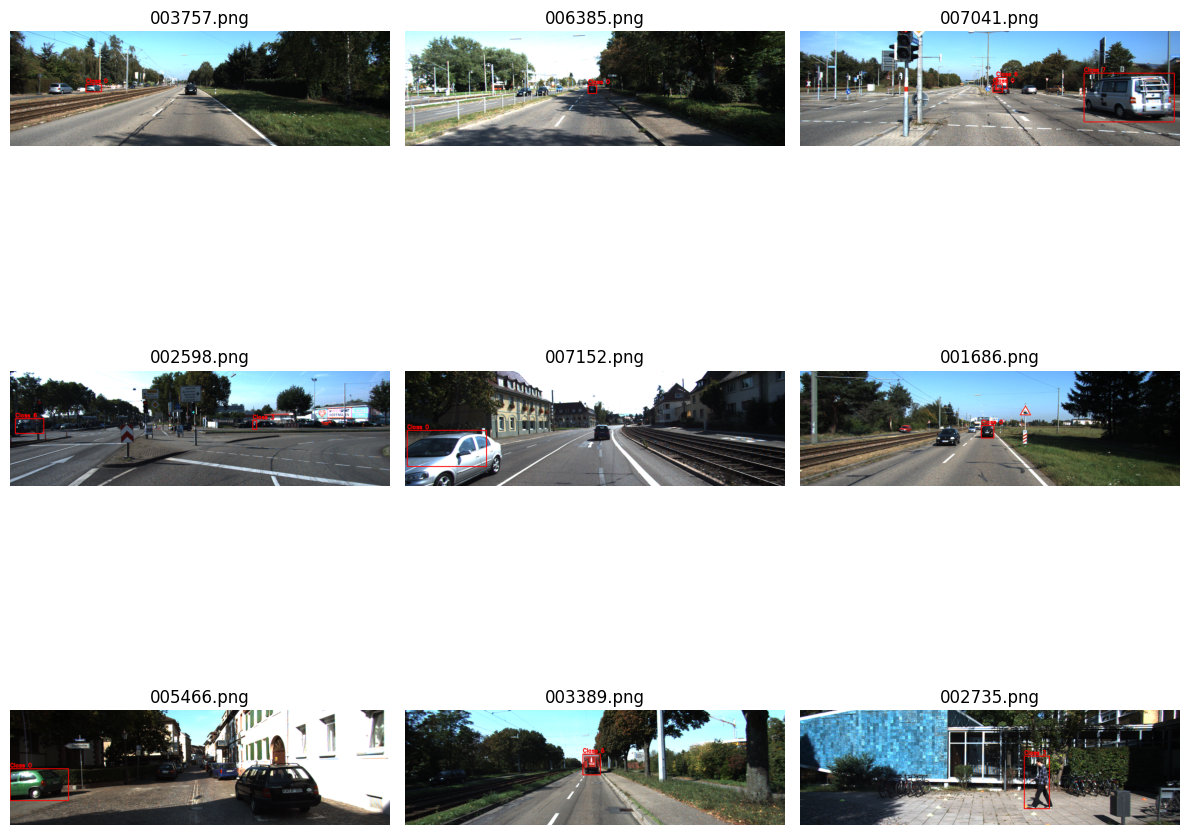

In [ ]:
def plot_random_images_with_boxes(split="balanced"):
    """
    Selects 9 random images from train or val and plots them with bounding boxes.
    :param split: "train" or "val" to choose from the respective dataset.
    """
    # Define paths
    images_dir = f"data/{split}/images"
    labels_dir = f"data/{split}/labels"

    # Get list of image files
    image_files = [f for f in os.listdir(images_dir) if f.endswith(".png")]
    
    if len(image_files) < 9:
        print("❌ Not enough images to plot (need at least 9).")
        return
    
    # Randomly select 9 images
    selected_images = random.sample(image_files, 9)

    # Create 3x3 plot
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    for idx, img_file in enumerate(selected_images):
        # Load image
        img_path = os.path.join(images_dir, img_file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper display
        
        # Load corresponding label file
        label_file = os.path.splitext(img_file)[0] + ".txt"
        label_path = os.path.join(labels_dir, label_file)

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                lines = f.readlines()

            # Image dimensions
            h, w, _ = image.shape
            
            # Draw bounding boxes
            for line in lines:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue  # Skip invalid lines

                class_id, x_center, y_center, width, height = map(float, parts)
                
                # Convert YOLO format (normalized) to pixel coordinates
                x_min = int((x_center - width / 2) * w)
                y_min = int((y_center - height / 2) * h)
                x_max = int((x_center + width / 2) * w)
                y_max = int((y_center + height / 2) * h)

                # Draw rectangle
                cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
                cv2.putText(image, f"Class {int(class_id)}", (x_min, y_min - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

        # Plot image in 3x3 grid
        ax = axes[idx // 3, idx % 3]
        ax.imshow(image)
        ax.axis("off")
        ax.set_title(img_file)

    plt.tight_layout()
    plt.show()

# Example usage: plot 9 random images from "train" or "val"
plot_random_images_with_boxes("balanced")  # Change to "val" for validation data


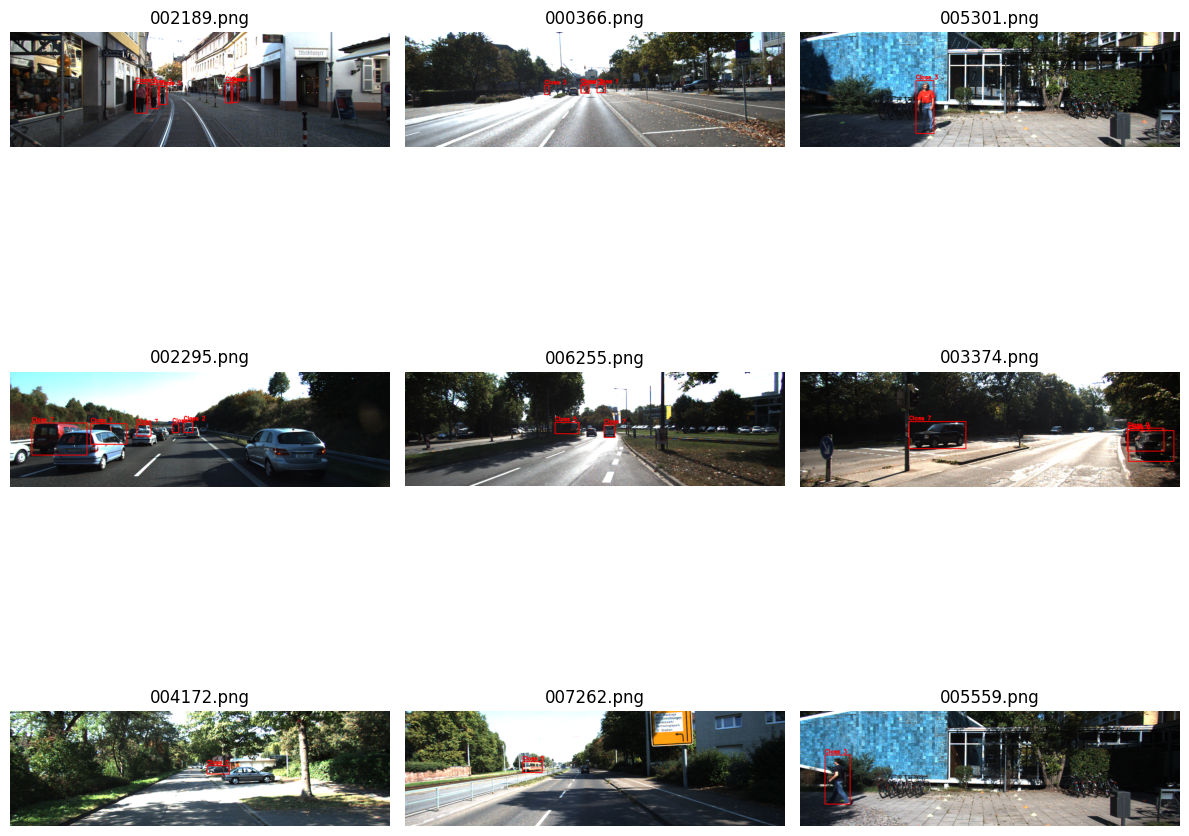

In [ ]:
plot_random_images_with_boxes("balanced")

The function successfully displayed random images with bounding boxes, proving that augmentations, oversampling, and synthetic data generation were applied correctly.

## 5. Model Training

In [ ]:
# Create output directory
output_dir = "runs/train/kitti_yolo_v8"
os.makedirs(output_dir, exist_ok=True)

# Load YOLOv8n model (pre-trained weights)
model = YOLO("yolov8n.pt")

# Train the model
results = model.train(
    data="/kaggle/working/data/dataset.yaml",  # Path to dataset.yaml
    imgsz=640,  # Image size
    epochs=50,  # Number of epochs
    batch=32,  # Adjust based on GPU memory
    name="kitti_yolo_v8",  # Experiment name
    save=True,  # Save model weights
    save_period=5,  # Save weights every 5 epochs
    project="runs/train",  # Path where logs and weights will be stored
    exist_ok=True  # Avoid overwriting existing results
)

print("✅ Training complete! Check saved weights and logs at:", output_dir)